In [1]:
import pandas as pd
import umap.plot as uplot
import umap.umap_ as umap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import matplotlib.pyplot as plt

c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
news = pd.read_csv('MIND_small/csv/news.csv')

In [3]:
news = news[news['abstract'].isna() == False]

In [4]:
news = news.drop(columns = ['Unnamed: 0', 'url', 'title_entities', 'abstract_entities'])

In [5]:
news

,news_id,category,sub_category,title,abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."
...,...,...,...,...,...
51275,N17258,news,newsscienceandtechnology,Realme takes chunk of India mobile market as S...,Over 400 percent more phones shipped year-on-year
51276,N23858,sports,golf,Young Northeast Florida fans flock to U.S. wom...,When the U.S. women's national soccer team arr...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b..."


In [6]:
news['title'] + news['abstract']

0        The Brands Queen Elizabeth, Prince Charles, an...
1        50 Worst Habits For Belly FatThese seemingly h...
2        The Cost of Trump's Aid Freeze in the Trenches...
3        I Was An NBA Wife. Here's How It Affected My M...
4        How to Get Rid of Skin Tags, According to a De...
                               ...                        
51275    Realme takes chunk of India mobile market as S...
51276    Young Northeast Florida fans flock to U.S. wom...
51277    Adapting, Learning And Soul Searching: Reflect...
51279    St. Dominic soccer player tries to kick cancer...
51280    How the Sounders won MLS CupMark, Jeremiah and...
Length: 48616, dtype: object

In [7]:
vectorizer = CountVectorizer(stop_words='english')
word_doc_matrix = vectorizer.fit_transform(news['abstract'] + news['title'])

In [8]:
word_doc_matrix

<48616x58449 sparse matrix of type '<class 'numpy.int64'>'
	with 1125113 stored elements in Compressed Sparse Row format>

In [9]:
embedding = umap.UMAP(n_components=2, metric='hellinger').fit(word_doc_matrix)

: 

In [ ]:
embedding

UMAP(angular_rp_forest=True, metric='hellinger', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

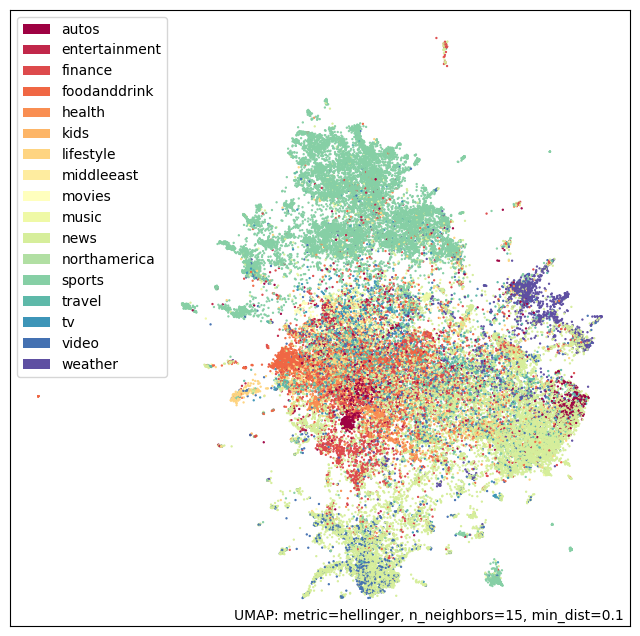

In [ ]:
uplot.points(embedding, labels=news['category'])

In [ ]:
import sklearn.cluster as cluster

In [ ]:
tfidfvectorizer = TfidfVectorizer(stop_words='english')
tfidf_mat = tfidfvectorizer.fit_transform(news['abstract'] + news['title'])

In [ ]:
kmeans_embedding_labels = cluster.KMeans(n_clusters=16).fit_predict(tfidf_mat)

c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\nicho\anaconda3\envs\recommenderEnv\lib\subprocess.py", line 1436, in _execute_child
    hp, h

In [ ]:
standard_embedding = umap.UMAP(n_components=2, metric='hellinger').fit_transform(tfidf_mat)

In [ ]:
# uplot.points(tf_embedding, labels=kmeans_embedding_labels)

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=10,
    random_state=42
).fit(tfidf_mat)

In [ ]:
import hdbscan

In [ ]:
labels = hdbscan.HDBSCAN().fit_predict(clusterable_embedding)

In [ ]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
uplot.points(clusterable_embedding, labels=news['category'])

In [ ]:
clusterable_embedding

In [ ]:
len(kmeans_embedding_labels)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
(
    adjusted_rand_score(news['category'], kmeans_embedding_labels),
    adjusted_mutual_info_score(news['category'], kmeans_embedding_labels)
)